## Newtonian-type2

初始时刻入口压力（MPa）：45.00000
初始时刻环空井底压力（MPa）：81.65185
初始时刻钻柱摩擦压降（MPa）： 2.70131
初始时刻环空摩擦压降（MPa）：40.76120
初始时刻钻头压降（MPa）： 0.00000


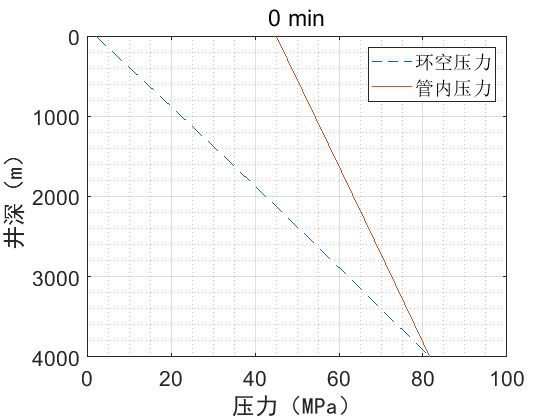

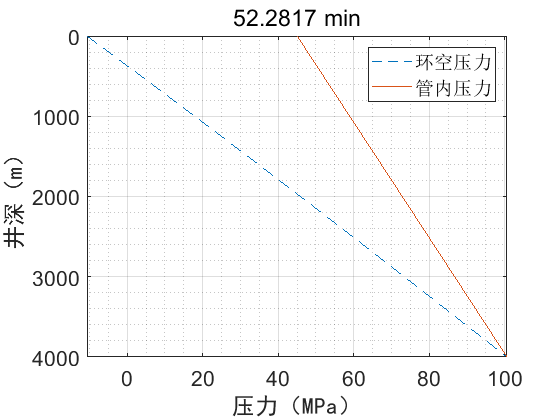

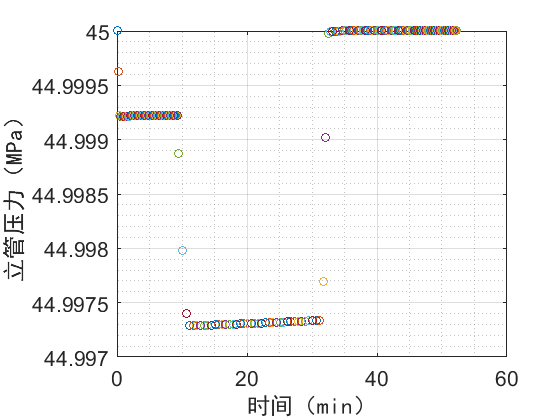

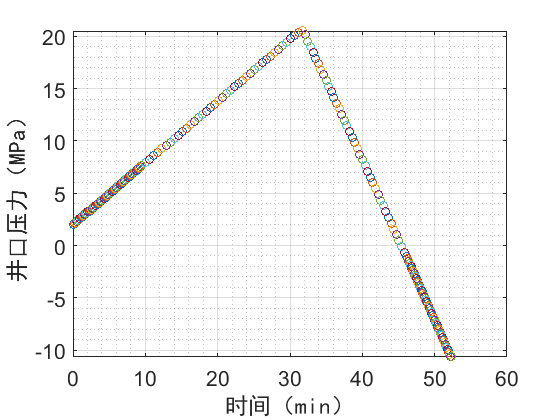

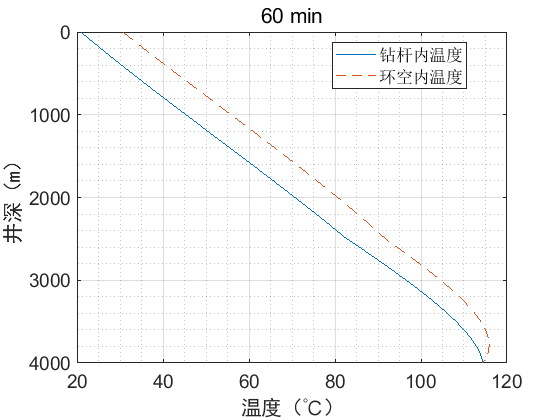

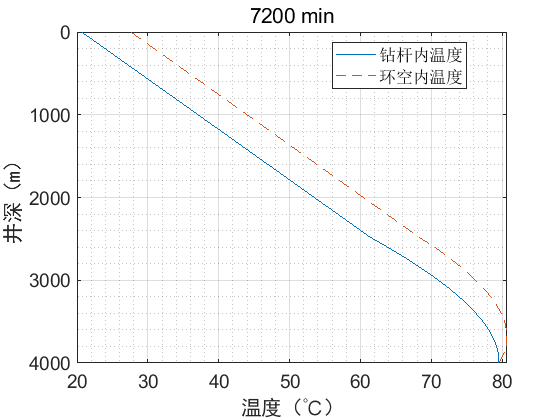

In [1]:
%% 流体流动方向计算（给定入口流量、入口压力）
close all;clear all;clc;
cd("D:\桌面\毕设\材料\20221127-结题材料\03-源代码\04 - 注替压力\01-Newtonian")
%% 基础数据及预处理（国际单位制）
T_0=20; % 流体性质（密度、流变参数）测试温度，℃
P_0=0.1*10^5; % 流体性质（密度、流变参数）测试压力，Pa
data_rheology_01=csvread('RheologyData_01.csv',1,0); % 导入第一种流体T_0、P_0下流变性测试数据
data_rheology_02=csvread('RheologyData_02.csv',1,0); % 导入第二种流体T_0、P_0下流变性测试数据
[mu_0_1]=Rheology_Newtonian(data_rheology_01); % 计算第一种流体T_0、P_0下粘度（Pa*s）
[mu_0_2]=Rheology_Newtonian(data_rheology_02); % 计算第二种流体T_0、P_0下粘度（Pa*s）
rho_0_1=1000; % 第一种流体T_0、P_0下密度，kg/m^3
rho_0_2=1500; % 第二种流体T_0、P_0下密度，kg/m^3

g=9.81; % 重力加速度，m/s^2
epsilon_e=1*10^(-4); % 迭代误差限
epsilon_t=1*10^5; % 迭代最大迭代次数

welldepth=4000; % 井深，m
nx=100; % 空间网格数
Nx=nx+1; % 空间节点数
for x=1:1:60
    dx(x)=20;%welldepth/nx; % 空间步长，m
end
for x=61:1:Nx-1
    dx(x)=(welldepth-20*60)/(Nx-60-1); % 空间步长，m
end

Depth(1)=0;
for x=2:1:Nx
    Depth(x)=Depth(x-1)+dx(x-1); % 井深，m
end

for x=1:1:Nx
    theta(x)=0; % 井斜角，°
end

for x=1:1:80
    D_w(x)=140*10^(-3); % 井眼直径，m
end
for x=81:1:Nx
    D_w(x)=140*10^(-3); % 井眼直径，m
end

for x=1:1:80
    D_d_o(x)=114.3*10^(-3); % 管柱外径，m
end
for x=81:1:Nx
    D_d_o(x)=114.3*10^(-3); % 管柱外径，m
end

for x=1:1:80
    D_d_i(x)=100.53*10^(-3); % 管柱内径，m
end
for x=81:1:Nx
    D_d_i(x)=100.53*10^(-3); % 管柱内径，m
end

for x=1:1:Nx
    A_d(x)=1/4*pi*D_d_i(x)^2; % 管内截面积，m^2
    A_a(x)=1/4*pi*(D_w(x)^2-D_d_o(x)^2); % 环空截面积，m^2
end

nt=nx; % 时间网格数
Nt=Nx; % 时间节点数

Qv_0=1/60; % 泵排量，m^3/s

for x=1:1:Nx
    V_d_0(x)=Qv_0/A_d(x); % 管内各空间节点流体流速，m/s
    V_a_0(x)=Qv_0/A_a(x); % 环空各空间节点流体流速，m/s
end

for x=1:1:Nx-1
    dt_d(x)=dx(x)/V_d_0(x); % 管内流体流经各网格所需时间，s
    dt_a(x)=dx(x)/V_a_0(x); % 环空流体流经各网格所需时间，s
end

for t=1:1:(Nt-1)
    dt(t)=dt_d(t); % 时间步长，s
end
for t=Nt:1:(2*Nt-2)
    dt(t)=dt_a(2*Nt-t-1); % 时间步长，s
end

t_inject_d(1)=0;
t_inject_a(1)=0;
for x=2:1:Nx
    t_inject_d(x)=t_inject_d(x-1)+dt_d(x-1); % 驱替管内流体所需时长，s
    t_inject_a(x)=t_inject_a(x-1)+dt_a(x-1); % 驱替环空流体所需时长，s
end
t_total=t_inject_d(Nx)+t_inject_a(Nx); % 总时长，s

%%
for t=1:1:(2*Nt-1)
    for x=1:1:Nx
        rho_a_0(t,x)=rho_0_1; % 初始时刻环空第t个时间节点第x个空间节点处流体T_0、P_0下的密度，kg/m^3
        rho_d_0(t,x)=rho_0_1; % 初始时刻管内第t个时间节点第x个空间节点处流体T_0、P_0下的密度，kg/m^3
        mu_a_0(t,x)=mu_0_1; % 初始时刻环空第t个时间节点第x个空间节点处流体T_0、P_0下的粘度，Pa*s
        mu_d_0(t,x)=mu_0_1; % 初始时刻管内第t个时间节点第x个空间节点处流体T_0、P_0下的粘度，Pa*s
    end
end

for t=1:1:Nt
    for x=1:1:Nx
        if x<=t
            rho_d_0(t,x)=rho_0_2; % 管内第t个时间节点第x个空间节点处流体T_0、P_0下的密度，kg/m^3
            mu_d_0(t,x)=mu_0_2; % 管内第t个时间节点第x个空间节点处流体T_0、P_0下的粘度，Pa*s
        else
            rho_d_0(t,x)=rho_0_1; % 管内第t个时间节点第x个空间节点处流体T_0、P_0下的密度，kg/m^3
            mu_d_0(t,x)=mu_0_1; % 管内第t个时间节点第x个空间节点处流体T_0、P_0下的粘度，Pa*s
        end
    end
end

for t=Nt:1:(2*Nt-1)
    for x=Nx:-1:1
        if x>=(2*Nt-t) %% Nx-x<=t-Nt
            rho_a_0(t,x)=rho_0_2; % 环空第t个时间节点第x个空间节点处流体T_0、P_0下的密度，kg/m^3
            mu_a_0(t,x)=mu_0_2; % 环空第t个时间节点第x个空间节点处流体T_0、P_0下的粘度，Pa*s
        else
            rho_a_0(t,x)=rho_0_1; % 环空第t个时间节点第x个空间节点处流体T_0、P_0下的密度，kg/m^3
            mu_a_0(t,x)=mu_0_1; % 环空第t个时间节点第x个空间节点处流体T_0、P_0下的粘度，Pa*s
        end
        rho_d_0(t,x)=rho_0_2; % 管内第t个时间节点第x个空间节点处流体T_0、P_0下的密度，kg/m^3
        mu_d_0(t,x)=mu_0_2; % 管内第t个时间节点第x个空间节点处流体T_0、P_0下的粘度，Pa*s
    end
end

for t=1:1:(2*Nt-1)
    for x=1:1:Nx
        Qm_d_0(t,x)=Qv_0*rho_d_0(t,x); % 管内第t个时间节点第x个空间节点处流体T_0、P_0下的质量流量，kg/s
        Qm_a_0(t,x)=Qv_0*rho_a_0(t,x); % 环空第t个时间节点第x个空间节点处流体T_0、P_0下的质量流量，kg/s
    end
end

C=0.95; % 喷嘴流量系数
d_nozzle=12.7*10^(-3); % 喷嘴直径，m
n_nozzle=3; % 喷嘴个数

InPressure=45*10^6; % 入口压力，Pa

for t=1:1:Nt
    IP(t)=InPressure; % 入口压力，Pa
end
for t=(Nt+1):1:(2*Nt-1)
    IP(t)=InPressure; % 入口压力，Pa
end

%% 温度计算
[T_a_T,T_d_T,Depth_T,Time_T]=Temperature(welldepth,(rho_0_1+rho_0_2)/2,(mu_0_1+mu_0_2)/2,Qv_0); % 计算温度场参数（环空温度（℃），管内温度（℃），空间节点（m），时间节点（s））

%% 插值计算空间节点Depth对应的环空温度T_A和管内温度T_D
[r,c]=size(T_a_T);
for t=1:1:c
    for x=1:1:Nx
        for i=1:1:r-1
            if Depth(x)>=Depth_T(i) && Depth(x)<Depth_T(i+1)
                T_A(x,t)=T_a_T(i,t)+(T_a_T(i+1,t)-T_a_T(i,t))*(Depth(x)-Depth_T(i))/(Depth_T(i+1)-Depth_T(i)); % 环空钻井液温度，℃
                T_D(x,t)=T_d_T(i,t)+(T_d_T(i+1,t)-T_d_T(i,t))*(Depth(x)-Depth_T(i))/(Depth_T(i+1)-Depth_T(i)); % 管内钻井液温度，℃
            elseif Depth(x)==Depth_T(i+1)
                T_A(x,t)=T_a_T(i+1,t); % 环空钻井液温度，℃
                T_D(x,t)=T_d_T(i+1,t); % 管内钻井液温度，℃
            end
        end
    end
end

for t=1:1:(2*Nt-1)
    T_a(t,:)=T_A(:,c); % 环空流体温度（假设每个时刻都一样），℃
    T_d(t,:)=T_D(:,c); % 管内流体温度（假设每个时刻都一样），℃
end

%% 第1个时间节点相关参数计算（管内）
% 第1个空间节点处相关参数计算
P_d(1,1)=InPressure; % 管内入口压力，Pa
rho_d(1,1)=Density_TP(rho_d_0(1,1),T_0,P_0,T_d(1,1),P_d(1,1)); % 管内入口流体密度，kg/m^3
Qv_d(1,1)=Qm_d_0(1,1)/rho_d(1,1); % 管内入口体积流量，m^3/s
V_d(1,1)=Qv_d(1,1)/A_d(1); % 管内入口流体流速，m/s
[mu_d(1,1)]=Rheology_TP(mu_d_0(1,1),T_0,P_0,T_d(1,1),P_d(1,1)); % 管内入口流体粘度，Pa*s
[Ff_d(1,1),flow_pattern_d(1,1)]=Friction_drillpipe(rho_d(1,1),V_d(1,1),mu_d(1,1),D_d_i(1)); % 管内入口单位长度摩擦压降（Pa/m）、流体流态（层流1、过渡流2、湍流3）
Fa_d(1,1)=0; % 管内入口单位长度加速度压降，Pa/m

% 第2～Nx个空间节点处相关参数计算
for x=2:1:Nx
    P_d_ass(1,x)=P_d(1,x-1)+rho_d(1,x-1)*g*cosd(theta(x-1))*dx(x-1); % 管内压力假设值，Pa
    
    ERROR_PipPressure=1; % 管内压力相对误差
    COUNT_PipPressure=0; % 迭代次数
    while abs(ERROR_PipPressure)>epsilon_e && COUNT_PipPressure<epsilon_t
        COUNT_PipPressure=COUNT_PipPressure+1;
        
        rho_d(1,x)=Density_TP(rho_d_0(1,x),T_0,P_0,T_d(1,x),P_d_ass(1,x)); % 管内流体密度，kg/m^3
        Qv_d(1,x)=Qm_d_0(1,x)/rho_d(1,x); % 管内体积流量，m^3/s
        V_d(1,x)=Qv_d(1,x)/A_d(x); % 管内流体流速，m/s
        [mu_d(1,x)]=Rheology_TP(mu_d_0(1,x),T_0,P_0,T_d(1,x),P_d_ass(1,x)); % 管内流体粘度，Pa*s
        [Ff_d(1,x),flow_pattern_d(1,x)]=Friction_drillpipe(rho_d(1,x),V_d(1,x),mu_d(1,x),D_d_i(x)); % 管内单位长度摩擦压降（Pa/m）、流体流态（层流1、过渡流2、湍流3）
        Fa_d(1,x)=abs(0.5*(rho_d(1,x)*V_d(1,x)^2-rho_d(1,x-1)*V_d(1,x-1)^2)); % 管内单位长度加速度压降，Pa/m
        P_d(1,x)=-rho_d(1,x)*V_d(1,x)^2+rho_d(1,x-1)*V_d(1,x-1)^2+P_d(1,x-1)+(((rho_d(1,x)*g*cosd(theta(x))-Ff_d(1,x)-Fa_d(1,x))+(rho_d(1,x-1)*g*cosd(theta(x-1))-Ff_d(1,x-1)-Fa_d(1,x-1)))/2)*dx(x-1); % 管内压力计算值，Pa
        
        ERROR_PipPressure=abs(P_d(1,x)-P_d_ass(1,x))/P_d_ass(1,x); % 管内压力相对误差
        P_d_ass(1,x)=P_d(1,x); % 新的管内压力假设值，Pa
    end
end

%% 第2～（2*Nt-1）个时间节点相关参数计算（管内）
for t=2:1:(2*Nt-1)
    P_d(t,Nx)=P_d(t-1,Nx); % 管内井底压力假设值，Pa
    
    ERROR_PipInPressure=1; % 管内入口压力相对误差
    COUNT_PipInPressure=0; % 迭代次数
    while abs(ERROR_PipInPressure)>epsilon_e && COUNT_PipInPressure<epsilon_t
        COUNT_PipInPressure=COUNT_PipInPressure+1;
        
        % 第Nx个空间节点处相关参数计算
        rho_d(t,Nx)=Density_TP(rho_d_0(t,Nx),T_0,P_0,T_d(t,Nx),P_d(t,Nx)); % 管内井底流体密度，kg/m^3
        Qv_d(t,Nx)=Qm_d_0(t,Nx)/rho_d(t,Nx); % 管内井底体积流量，m^3/s
        V_d(t,Nx)=Qv_d(t,Nx)/A_d(Nx); % 管内井底流体流速，m/s
        [mu_d(t,Nx)]=Rheology_TP(mu_d_0(t,Nx),T_0,P_0,T_d(t,Nx),P_d(t,Nx)); % 管内井底流体粘度（Pa*s）
        [Ff_d(t,Nx),flow_pattern_d(t,Nx)]=Friction_drillpipe(rho_d(t,Nx),V_d(t,Nx),mu_d(t,Nx),D_d_i(Nx)); % 管内井底单位长度摩擦压降（Pa/m）、流体流态（层流1、过渡流2、湍流3）
        Fa_d(t,Nx)=0; % 管内井底单位长度加速度压降，Pa/m
        
        % 第Nx-1～1个空间节点处相关参数计算
        for x=Nx-1:-1:1
            P_d_ass(t,x)=P_d(t,x+1)-rho_d(t,x+1)*g*cosd(theta(x+1))*dx(x); % 管内压力假设值，Pa
            
            ERROR_PipPressure=1; % 管内压力相对误差
            COUNT_PipPressure=0; % 迭代次数
            while abs(ERROR_PipPressure)>epsilon_e && COUNT_PipPressure<epsilon_t
                COUNT_PipPressure=COUNT_PipPressure+1;
                
                rho_d(t,x)=Density_TP(rho_d_0(t,x),T_0,P_0,T_d(t,x),P_d_ass(t,x)); % 管内流体密度，kg/m^3
                Qv_d(t,x)=Qm_d_0(t,x)/rho_d(t,x); % 管内体积流量，m^3/s
                V_d(t,x)=Qv_d(t,x)/A_d(x); % 管内流体流速，m/s
                [mu_d(t,x)]=Rheology_TP(mu_d_0(t,x),T_0,P_0,T_d(t,x),P_d_ass(t,x)); % 管内流体粘度（Pa*s）
                [Ff_d(t,x),flow_pattern_d(t,x)]=Friction_drillpipe(rho_d(t,x),V_d(t,x),mu_d(t,x),D_d_i(x)); % 管内单位长度摩擦压降（Pa/m）、流体流态（层流1、过渡流2、湍流3）
                Fa_d(t,x)=abs(0.5*(rho_d(t,x+1)*V_d(t,x+1)^2-rho_d(t,x)*V_d(t,x)^2)); % 管内单位长度加速度压降，Pa/m
                M1=(((rho_d(t,x)*V_d(t,x)+rho_d(t,x+1)*V_d(t,x+1))-(rho_d(t-1,x)*V_d(t-1,x)+rho_d(t-1,x+1)*V_d(t-1,x+1)))*dx(x))/(2*dt(t-1));
                M2=((rho_d(t,x+1)*V_d(t,x+1)^2+rho_d(t-1,x+1)*V_d(t-1,x+1)^2)-(rho_d(t,x)*V_d(t,x)^2+rho_d(t-1,x)*V_d(t-1,x)^2))/2;
                M3=-(((rho_d(t,x)*g*cosd(theta(x))-Ff_d(t,x)-Fa_d(t,x))+(rho_d(t,x+1)*g*cosd(theta(x+1))-Ff_d(t,x+1)-Fa_d(t,x+1))+(rho_d(t-1,x)*g*cosd(theta(x))-Ff_d(t-1,x)-Fa_d(t-1,x))+(rho_d(t-1,x+1)*g*cosd(theta(x+1))-Ff_d(t-1,x+1)-Fa_d(t-1,x+1)))*dx(x))/4;
                P_d(t,x)=P_d(t,x+1)+M1+M2+M3; % 管内压力计算值，Pa
                
                ERROR_PipPressure=abs(P_d(t,x)-P_d_ass(t,x))/P_d_ass(t,x); % 管内压力相对误差
                P_d_ass(t,x)=P_d(t,x); % 新的管内压力假设值，Pa
            end
        end
        
        ERROR_PipInPressure=abs(P_d(t,1)-IP(t))/IP(t); % 管内入口压力相对误差
        P_d(t,Nx)=P_d(t,Nx)-(P_d(t,1)-IP(t)); % 新的井底压力假设值，Pa
    end
end

%% 第1～（2*Nt-1）个时间节点钻头压降计算
for t=1:1:(2*Nt-1)
%     [delta_P_bit(t),V_nozzle(t)]=PressureDrop_Bit(C,d_nozzle,n_nozzle,Qv_d(t,Nx),rho_d(t,Nx)); % 钻头压降（Pa）、喷嘴流速（m/s）
    delta_P_bit(t)=0; % 钻头压降，Pa
end

%% 第1个时间节点相关参数计算（环空）
% 第Nx个空间节点处相关参数计算
P_a(1,Nx)=P_d(1,Nx)-delta_P_bit(1); % 环空井底压力，Pa
rho_a(1,Nx)=Density_TP(rho_a_0(1,Nx),T_0,P_0,T_a(1,Nx),P_a(1,Nx)); % 环空井底流体密度，kg/m^3
Qv_a(1,Nx)=Qm_a_0(1,Nx)/rho_a(1,Nx); % 环空井底体积流量，m^3/s
V_a(1,Nx)=Qv_a(1,Nx)/A_a(Nx); % 环空井底流体流速，m/s
[mu_a(1,Nx)]=Rheology_TP(mu_a_0(1,Nx),T_0,P_0,T_a(1,Nx),P_a(1,Nx)); % 环空井底流体粘度（Pa*s）
[Ff_a(1,Nx),flow_pattern_a(1,Nx)]=Friction_annulus(rho_a(1,Nx),V_a(1,Nx),mu_a(1,Nx),D_w(Nx),D_d_o(Nx)); % 环空井底单位长度摩擦压降（Pa/m）、流体流态（层流1、过渡流2、湍流3）
Fa_a(1,Nx)=0; % 环空井底单位长度加速度压降，Pa/m

% 第Nx-1～1个空间节点处相关参数计算
for x=Nx-1:-1:1
    P_a_ass(1,x)=P_a(1,x+1)-rho_a(1,x+1)*g*cosd(theta(x+1))*dx(x); % 环空压力假设值，Pa
    
    ERROR_AnnPressure=1; % 环空压力相对误差
    COUNT_AnnPressure=0; % 迭代次数
    while abs(ERROR_AnnPressure)>epsilon_e && COUNT_AnnPressure<epsilon_t
        COUNT_AnnPressure=COUNT_AnnPressure+1;
        
        rho_a(1,x)=Density_TP(rho_a_0(1,x),T_0,P_0,T_a(1,x),P_a_ass(1,x)); % 环空流体密度，kg/m^3
        Qv_a(1,x)=Qm_a_0(1,x)/rho_a(1,x); % 环空出口体积流量，m^3/s
        V_a(1,x)=Qv_a(1,x)/A_a(x); % 环空流体流速，m/s
        [mu_a(1,x)]=Rheology_TP(mu_a_0(1,x),T_0,P_0,T_a(1,x),P_a_ass(1,x)); % 环空流体粘度（Pa*s）
        [Ff_a(1,x),flow_pattern_a(1,x)]=Friction_annulus(rho_a(1,x),V_a(1,x),mu_a(1,x),D_w(x),D_d_o(x)); % 环空单位长度摩擦压降（Pa/m）、流体流态（层流1、过渡流2、湍流3）
        Fa_a(1,x)=abs(0.5*(rho_a(1,x)*V_a(1,x)^2-rho_a(1,x+1)*V_a(1,x+1)^2)); % 环空单位长度加速度压降，Pa/m
        P_a(1,x)=-rho_a(1,x)*V_a(1,x)^2+rho_a(1,x+1)*V_a(1,x+1)^2+P_a(1,x+1)+(((-rho_a(1,x)*g*cosd(theta(x))-Ff_a(1,x)-Fa_a(1,x))+(-rho_a(1,x+1)*g*cosd(theta(x+1))-Ff_a(1,x+1)-Fa_a(1,x+1)))*dx(x))/2; % 环空压力计算值，Pa
        
        ERROR_AnnPressure=abs(P_a(1,x)-P_a_ass(1,x))/P_a_ass(1,x); % 环空压力相对误差
        P_a_ass(1,x)=P_a(1,x); % 新的环空压力假设值，Pa
    end
end

%% 第2～（2*Nt-1）个时间节点相关参数计算（环空）
for t=2:1:(2*Nt-1)
    P_a_REAL(t,Nx)=P_d(t,Nx)-delta_P_bit(t); % 环空井底压力，Pa
    P_a(t,1)=P_a(t-1,1); % 环空出口压力假设值，Pa
    
    ERROR_AnnInPressure=1; % 环空井底压力相对误差
    COUNT_AnnInPressure=0; % 迭代次数
    while abs(ERROR_AnnInPressure)>epsilon_e && COUNT_AnnInPressure<epsilon_t
        COUNT_AnnInPressure=COUNT_AnnInPressure+1;
        
        % 第1个空间节点处相关参数计算
        rho_a(t,1)=Density_TP(rho_a_0(t,1),T_0,P_0,T_a(t,1),P_a(t,1)); % 环空出口流体密度，kg/m^3
        Qv_a(t,1)=Qm_a_0(t,1)/rho_a(t,1); % 环空出口体积流量，m^3/s
        V_a(t,1)=Qv_a(t,1)/A_a(1); % 环空出口流体流速，m/s
        [mu_a(t,1)]=Rheology_TP(mu_a_0(t,1),T_0,P_0,T_a(t,1),P_a(t,1)); % 环空出口流体粘度（Pa*s）
        [Ff_a(t,1),flow_pattern_a(t,1)]=Friction_annulus(rho_a(t,1),V_a(t,1),mu_a(t,1),D_w(1),D_d_o(1)); % 环空出口单位长度摩擦压降（Pa/m）、流体流态（层流1、过渡流2、湍流3）
        Fa_a(t,1)=0; % 环空出口单位长度加速度压降，Pa/m
        
        % 第2～Nx个空间节点处相关参数计算
        for x=2:1:Nx
            P_a_ass(t,x)=P_a(t,x-1)+rho_a(t,x-1)*g*cosd(theta(x-1))*dx(x-1); % 环空压力假设值，Pa
            
            ERROR_AnnPressure=1; % 环空压力相对误差
            COUNT_AnnPressure=0; % 迭代次数
            while abs(ERROR_AnnPressure)>epsilon_e && COUNT_AnnPressure<epsilon_t
                COUNT_AnnPressure=COUNT_AnnPressure+1;
                
                rho_a(t,x)=Density_TP(rho_a_0(t,x),T_0,P_0,T_a(t,x),P_a_ass(t,x)); % 环空流体密度，kg/m^3
                Qv_a(t,x)=Qm_a_0(t,x)/rho_a(t,x); % 环空体积流量，m^3/s
                V_a(t,x)=Qv_a(t,x)/A_a(x); % 环空流体流速，m/s
                [mu_a(t,x)]=Rheology_TP(mu_a_0(t,x),T_0,P_0,T_a(t,x),P_a_ass(t,x)); % 环空流体粘度（Pa*s）
                [Ff_a(t,x),flow_pattern_a(t,x)]=Friction_annulus(rho_a(t,x),V_a(t,x),mu_a(t,x),D_w(x),D_d_o(x)); % 环空流体单位长度摩擦压降（Pa/m）、流体流态（层流1、过渡流2、湍流3）
                Fa_a(t,x)=abs(0.5*(rho_a(t,x-1)*V_a(t,x-1)^2-rho_a(t,x)*V_a(t,x)^2)); % 环空单位长度加速度压降，Pa/m
                M1=(((rho_a(t,x-1)*V_a(t,x-1)+rho_a(t,x)*V_a(t,x))-(rho_a(t-1,x-1)*V_a(t-1,x-1)+rho_a(t-1,x)*V_a(t-1,x)))*dx(x-1))/(2*dt(t-1));
                M2=((rho_a(t-1,x-1)*V_a(t-1,x-1)^2+rho_a(t,x-1)*V_a(t,x-1)^2)-(rho_a(t-1,x)*V_a(t-1,x)^2+rho_a(t,x)*V_a(t,x)^2))/2;
                M3=-(((-rho_a(t,x)*g*cosd(theta(x))-Ff_a(t,x)-Fa_a(t,x))+(-rho_a(t,x-1)*g*cosd(theta(x-1))-Ff_a(t,x-1)-Fa_a(t,x-1))+(-rho_a(t-1,x)*g*cosd(theta(x))-Ff_a(t-1,x)-Fa_a(t-1,x))+(-rho_a(t-1,x-1)*g*cosd(theta(x-1))-Ff_a(t-1,x-1)-Fa_a(t-1,x-1)))*dx(x-1))/4;
                P_a(t,x)=P_a(t,x-1)+M1+M2+M3; % 环空压力计算值，Pa
                
                ERROR_AnnPressure=abs(P_a(t,x)-P_a_ass(t,x))/P_a_ass(t,x); % 环空压力相对误差
                P_a_ass(t,x)=P_a(t,x); % 新的环空压力假设值，Pa
            end
        end
        
        ERROR_AnnInPressure=abs(P_a(t,Nx)-P_a_REAL(t,Nx))/P_a_REAL(t,Nx); % 环空井底压力相对误差
        P_a(t,1)=P_a(t,1)-(P_a(t,Nx)-P_a_REAL(t,Nx)); % 新的环空出口压力假设值，Pa
    end
end

%% 摩擦压降计算
for t=1:1:(2*Nt-1)
    FrictionalPressureDrop_annulus(t,1)=0; % FrictionalPressureDrop_annulus为环空摩擦压降，Pa
    FrictionalPressureDrop_drillpipe(t,1)=0; % FrictionalPressureDrop_drillpipe为钻杆摩擦压降，Pa
    for x=2:1:Nx
        FrictionalPressureDrop_annulus(t,x)=FrictionalPressureDrop_annulus(t,x-1)+Ff_a(t,x)*dx(x-1); % 沿井深对环空摩擦压降累计求和，Pa
        FrictionalPressureDrop_drillpipe(t,x)=FrictionalPressureDrop_drillpipe(t,x-1)+Ff_d(t,x)*dx(x-1); % 沿井深对钻杆摩擦压降累计求和，Pa
    end
end

%% 输出数据
fprintf('初始时刻入口压力（MPa）：%8.5f\n',P_d(1,1)/(10^6)); % 初始时刻入口压力，MPa
fprintf('初始时刻环空井底压力（MPa）：%8.5f\n',P_a(1,Nx)/(10^6)); % 初始时刻环空井底压力，MPa
fprintf('初始时刻钻柱摩擦压降（MPa）：%8.5f\n',FrictionalPressureDrop_drillpipe(1,Nx)/(10^6)); % 初始时刻钻柱摩擦压降，MPa
fprintf('初始时刻环空摩擦压降（MPa）：%8.5f\n',FrictionalPressureDrop_annulus(1,Nx)/(10^6)); % 初始时刻环空摩擦压降，MPa
fprintf('初始时刻钻头压降（MPa）：%8.5f\n',delta_P_bit(1)/(10^6)); % 初始时刻钻头压降，MPa

%% 绘制图像
Time(1)=0;
for t=2:1:Nt
    Time(t)=Time(t-1)+dt_d(t-1);
end
for t=Nt+1:1:(2*Nt-1)
    Time(t)=Time(t-1)+dt_a(2*Nt-t);
end

figure(1); % 环空管内压力VS井深VS时间
for t=1:1:(2*Nt-1)
    plot(P_a(t,:)/10^6,Depth,'--',P_d(t,:)/10^6,Depth); % 环空、管内压力（MPa）
    xlabel('压力（MPa）','FontName','黑体','FontSize',16);
    ylabel('井深（m）','FontName','黑体','FontSize',16);
    title([num2str(Time(t)/60),' min']);
    legend('环空压力','管内压力');
    set(gca,'fontsize',16);
    set(gca,'YDir','reverse');
    box on; % 显示坐标轴的边框
    grid on; % 显示坐标轴的主网格线
    grid minor; % 显示坐标轴的次网格线
    
    pause(0.001);
    
    % 导出gif动图
    drawnow;
    F1=getframe(gcf);
    I1=frame2im(F1);
    [I1,map1]=rgb2ind(I1,256);
    if t == 1
        imwrite(I1,map1,'环空管内压力VS井深VS时间.gif','gif','Loopcount',inf,'DelayTime',0.2);
    else
        imwrite(I1,map1,'环空管内压力VS井深VS时间.gif','gif','WriteMode','append','DelayTime',0.2);
    end
end

figure(2); % 立管压力VS时间
for t=1:1:(2*Nt-1)
    scatter(Time(t)/60,P_d(t,1)/10^6); % 立管压力（MPa）
    hold on;
    xlabel('时间（min）','FontName','黑体','FontSize',16);
    ylabel('立管压力（MPa）','FontName','黑体','FontSize',16);
    set(gca,'fontsize',16);
    box on; % 显示坐标轴的边框
    grid on; % 显示坐标轴的主网格线
    grid minor; % 显示坐标轴的次网格线
    
    pause(0.001);
    
    % 导出gif动图
    drawnow;
    F2=getframe(gcf);
    I2=frame2im(F2);
    [I2,map2]=rgb2ind(I2,256);
    if t == 1
        imwrite(I2,map2,'立管压力VS时间.gif','gif','Loopcount',inf,'DelayTime',0.2);
    else
        imwrite(I2,map2,'立管压力VS时间.gif','gif','WriteMode','append','DelayTime',0.2);
    end
end

figure(3); % 井口压力VS时间
for t=1:1:(2*Nt-1)
    scatter(Time(t)/60,P_a(t,1)/10^6); % 井口压力（MPa）
    hold on;
    xlabel('时间（min）','FontName','黑体','FontSize',16);
    ylabel('井口压力（MPa）','FontName','黑体','FontSize',16);
    set(gca,'fontsize',16);
    box on; % 显示坐标轴的边框
    grid on; % 显示坐标轴的主网格线
    grid minor; % 显示坐标轴的次网格线
    
    pause(0.001);
    
    % 导出gif动图
    drawnow;
    F3=getframe(gcf);
    I3=frame2im(F3);
    [I3,map3]=rgb2ind(I3,256);
    if t == 1
        imwrite(I3,map3,'井口压力VS时间.gif','gif','Loopcount',inf,'DelayTime',0.2);
    else
        imwrite(I3,map3,'井口压力VS时间.gif','gif','WriteMode','append','DelayTime',0.2);
    end
end

figure(4); % 井筒温度VS井深VS时间
for t = 1:1:length(Time_T)
    plot(T_d_T(:,t),Depth_T,T_a_T(:,t),Depth_T,'--'); % 井筒温度，℃
    xlabel('温度（℃）','FontName','黑体','FontSize',10);
    ylabel('井深（m）','FontName','黑体','FontSize',10);
    title([num2str(Time_T(t)/60),' min']);
    set(gca,'YDir','reverse');
    legend('钻杆内温度','环空内温度','Location','Best');
    set(gca,'FontSize',14);
    box on; % 显示坐标轴的边框
    grid on; % 显示坐标轴的主网格线
    grid minor; % 显示坐标轴的次网格线
    
    pause(0.001);
    
    % 导出gif动图
    drawnow;
    F4=getframe(gcf);
    I4=frame2im(F4);
    [I4,map4]=rgb2ind(I4,256);
    if t == 1
        imwrite(I4,map4,'井筒温度VS井深VS时间.gif','gif','Loopcount',inf,'DelayTime',0.2);
    else
        imwrite(I4,map4,'井筒温度VS井深VS时间.gif','gif','WriteMode','append','DelayTime',0.2);
    end
end